In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from abmax.structs import *


import seaborn as sns
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

MAX_SPAWN_X = 100
MAX_SPAWN_Y = MAX_SPAWN_X
PATCH_RADIUS = 5.0
FORAGER_RADIUS = 5.0
EP_LEN = 2000
NUM_FORAGERS = 10
NUM_PATCH = 10

In [2]:
from matplotlib.collections import LineCollection
import numpy as np

def render_static_trajectory(render_data, figname):#, filename='forager_trajectory_static.png'):
    # Extract data
    forager_xs = render_data.content['forager_xs']  # shape: (EP_LEN, NUM_FORAGERS)
    forager_ys = render_data.content['forager_ys']  # shape: (EP_LEN, NUM_FORAGERS)
    forager_angs = render_data.content['forager_angs']  # shape: (EP_LEN, NUM_FORAGERS)
    
    # Setup figure
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(-1.2*MAX_SPAWN_X, 1.2*MAX_SPAWN_X)
    ax.set_ylim(-1.2*MAX_SPAWN_Y, 1.2*MAX_SPAWN_Y)
    ax.set_aspect('equal')
    ax.set_xticks(jnp.arange(-0.6*MAX_SPAWN_X, 1.2*MAX_SPAWN_X+1, 60))
    ax.set_yticks(jnp.arange(-1.2*MAX_SPAWN_Y, 1.2*MAX_SPAWN_Y+1, 60))
    ax.tick_params(axis='both', which='major', labelsize=22)

    
    # Plot trajectories for each forager with gradient coloring
    for i in range(NUM_FORAGERS):
        # Extract trajectory for this forager
        x_traj = np.array(forager_xs[:, i])
        y_traj = np.array(forager_ys[:, i])
        
        # Create segments for the line collection
        points = np.array([x_traj, y_traj]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create gradient coloring (light at start, dark at end)
        cmap = plt.cm.Blues
        norm = plt.Normalize(0, len(segments))
        lc = LineCollection(segments, cmap=cmap, norm=norm, alpha=0.7, linewidth=1.0)
        
        # Set gradient from dark to light (don't invert the array)
        lc.set_array(np.arange(len(segments)))
        
        # Add line collection to plot
        ax.add_collection(lc)
        
        # Add 'X' marker at starting point
        ax.plot(x_traj[0], y_traj[0], 'X', color='blue', markersize=8, label='Start' if i == 0 else "")
    
    # Final positions with orientation arrows
    final_xs = forager_xs[-1, :]
    final_ys = forager_ys[-1, :]
    final_angs = forager_angs[-1, :]
    
    #make foragers opaque by changing alpha to 1.0
    forager_scatter = ax.scatter(final_xs, final_ys, c='b', s=FORAGER_RADIUS*100, 
                                alpha=0.8, edgecolors='black', linewidths=1.5, label='Foragers')
    forager_quiver = ax.quiver(final_xs, final_ys, 
                              jnp.cos(final_angs), jnp.sin(final_angs), 
                              color='b', scale=20.0)
    #add a dummy line for the trajectory legend
    ax.plot([], [], color='tab:blue', alpha=0.9, lw=1.2, label='Trajectory')

    #plt.legend(loc='upper right', fontsize=22)
    plt.savefig(figname, bbox_inches='tight')
    
    plt.show()


def plot_nn_distance_comparison(RENDER_DATA_PATH_non_ablated, RENDER_DATA_PATH_ablated, figname):
    mean_nn_dist_non_ablated = jnp.load(RENDER_DATA_PATH_non_ablated + 'rendering_forager_avg_NN_dists.npy')
    mean_nn_dist_ablated = jnp.load(RENDER_DATA_PATH_ablated + 'rendering_forager_avg_NN_dists.npy')
    print(mean_nn_dist_non_ablated.shape, mean_nn_dist_ablated.shape)

    std_dev_non_ablated = jnp.std(mean_nn_dist_non_ablated, axis=0)
    std_dev_ablated = jnp.std(mean_nn_dist_ablated, axis=0)
    print(std_dev_non_ablated.shape, std_dev_ablated.shape)

    mean_nn_dist_non_ablated = jnp.mean(mean_nn_dist_non_ablated, axis=0)
    mean_nn_dist_ablated = jnp.mean(mean_nn_dist_ablated, axis=0)
    print(mean_nn_dist_non_ablated.shape, mean_nn_dist_ablated.shape)


    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlabel('Timestep', fontsize=15)
    ax.set_ylabel('Nearest neighbor distance', fontsize=15)
    ax.set_xticks(jnp.arange(0, 2500, 500))

    ax.plot(mean_nn_dist_non_ablated, label='Non-ablated', linestyle='-')
    ax.fill_between(jnp.arange(len(mean_nn_dist_non_ablated)),
                mean_nn_dist_non_ablated - std_dev_non_ablated, mean_nn_dist_non_ablated + std_dev_non_ablated, alpha=0.2)
    ax.plot(mean_nn_dist_ablated, label='Ablated', linestyle='--')
    ax.fill_between(jnp.arange(len(mean_nn_dist_ablated)),
                mean_nn_dist_ablated - std_dev_ablated, mean_nn_dist_ablated + std_dev_ablated, alpha=0.2)
    ax.legend(loc='lower left', fontsize=18)

    plt.savefig(figname, bbox_inches='tight')

(5, 2000, 10, 1) (5, 2000, 10, 1) (5, 2000, 10, 1) (5, 2000, 10, 1)
(5, 2000, 10) (5, 2000, 10) (5, 2000, 10) (5, 2000, 10)
(2000, 10) (2000, 10) (2000, 10) (2000, 10)
[[  9.98       9.98       9.98     ...   9.98       9.98       9.98    ]
 [  9.959999   9.959999   9.959999 ...   9.959999   9.959999   9.959999]
 [  9.939999   9.939999   9.939999 ...   9.939999   9.939999   9.939999]
 ...
 [-29.960533 -29.960533 -29.960533 ... -29.960533 -29.960533 -29.960533]
 [-29.980534 -29.980534 -29.980534 ... -29.980534 -29.980534 -29.980534]
 [-30.000534 -30.000534 -30.000534 ... -30.000534 -30.000534 -30.000534]]


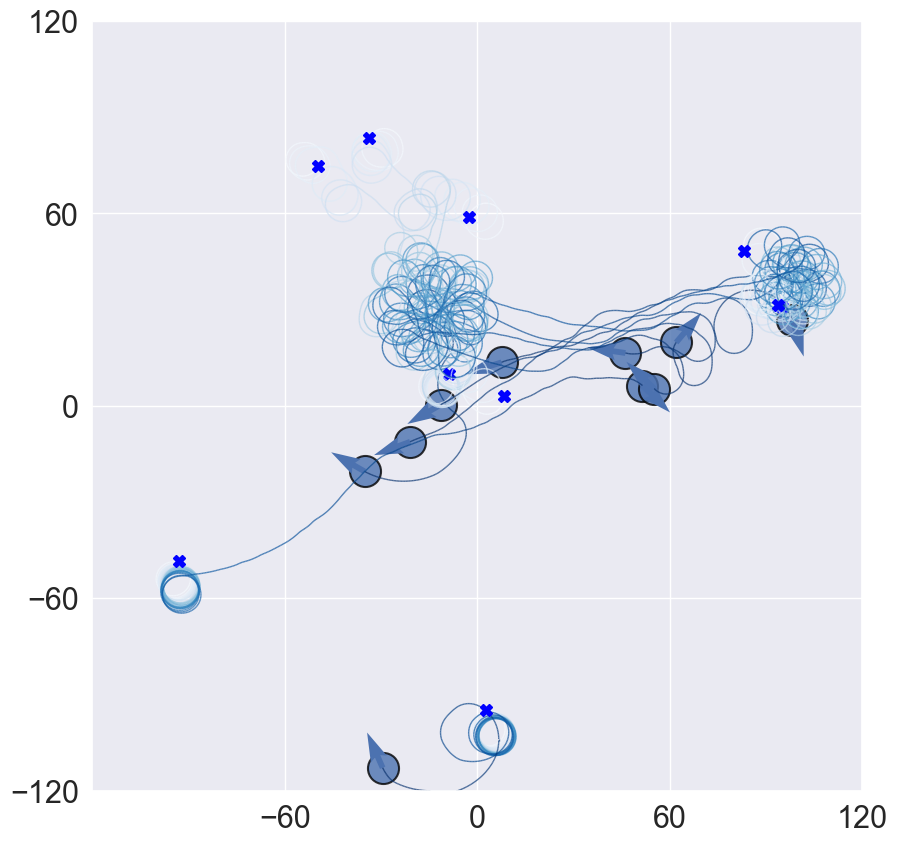

In [3]:
RENDER_DATA_PATH = "./trajectories_s_7/non_ablated/"

forager_xs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_xs.npy')
forager_ys = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_ys.npy')
forager_angs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_angs.npy')
forager_energies = jnp.load(RENDER_DATA_PATH + 'rendering_forager_energies.npy')
print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

forager_xs = jnp.reshape(forager_xs, (forager_xs.shape[0], EP_LEN, NUM_FORAGERS))
forager_ys = jnp.reshape(forager_ys, (forager_ys.shape[0], EP_LEN, NUM_FORAGERS))
forager_angs = jnp.reshape(forager_angs, (forager_angs.shape[0], EP_LEN, NUM_FORAGERS))
forager_energies = jnp.reshape(forager_energies, (forager_energies.shape[0], EP_LEN, NUM_FORAGERS))
print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

forager_xs = forager_xs[0]
forager_ys = forager_ys[0]
forager_angs = forager_angs[0]
forager_energies = forager_energies[0]

print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

print(forager_energies)

render_data = Params(
    content={
        'forager_xs': forager_xs,
        'forager_ys': forager_ys,
        'forager_angs': forager_angs
    }
)
render_static_trajectory(render_data, figname="./figs/non_ablated_s_7.png")

(5, 2000, 10, 1) (5, 2000, 10, 1) (5, 2000, 10, 1) (5, 2000, 10, 1)
(5, 2000, 10) (5, 2000, 10) (5, 2000, 10) (5, 2000, 10)
(2000, 10) (2000, 10) (2000, 10) (2000, 10)
[[  9.98       9.98       9.98     ...   9.98       9.98       9.98    ]
 [  9.959999   9.959999   9.959999 ...   9.959999   9.959999   9.959999]
 [  9.939999   9.939999   9.939999 ...   9.939999   9.939999   9.939999]
 ...
 [-29.960533 -29.960533 -29.960533 ... -29.960533 -29.960533 -29.960533]
 [-29.980534 -29.980534 -29.980534 ... -29.980534 -29.980534 -29.980534]
 [-30.000534 -30.000534 -30.000534 ... -30.000534 -30.000534 -30.000534]]


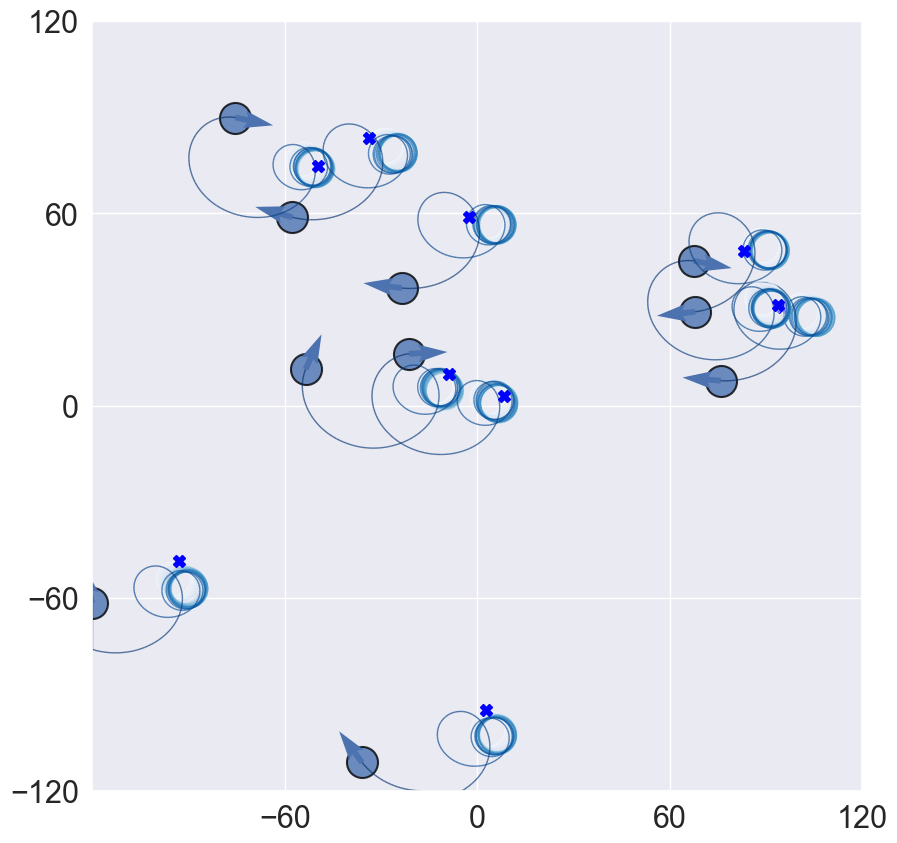

In [4]:
RENDER_DATA_PATH = "./trajectories_s_7/ablated/"

forager_xs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_xs.npy')
forager_ys = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_ys.npy')
forager_angs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_angs.npy')
forager_energies = jnp.load(RENDER_DATA_PATH + 'rendering_forager_energies.npy')
print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

forager_xs = jnp.reshape(forager_xs, (forager_xs.shape[0], EP_LEN, NUM_FORAGERS))
forager_ys = jnp.reshape(forager_ys, (forager_ys.shape[0], EP_LEN, NUM_FORAGERS))
forager_angs = jnp.reshape(forager_angs, (forager_angs.shape[0], EP_LEN, NUM_FORAGERS))
forager_energies = jnp.reshape(forager_energies, (forager_energies.shape[0], EP_LEN, NUM_FORAGERS))
print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

forager_xs = forager_xs[0]
forager_ys = forager_ys[0]
forager_angs = forager_angs[0]
forager_energies = forager_energies[0]

print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

print(forager_energies)

render_data = Params(
    content={
        'forager_xs': forager_xs,
        'forager_ys': forager_ys,
        'forager_angs': forager_angs
    }
)
render_static_trajectory(render_data, figname="./figs/ablated_s_7.png")

(5, 2000, 10, 1) (5, 2000, 10, 1) (5, 2000, 10, 1) (5, 2000, 10, 1)
(5, 2000, 10) (5, 2000, 10) (5, 2000, 10) (5, 2000, 10)
(2000, 10) (2000, 10) (2000, 10) (2000, 10)
[[  9.98       9.98       9.98     ...   9.98       9.98       9.98    ]
 [  9.959999   9.959999   9.959999 ...   9.959999   9.959999   9.959999]
 [  9.939999   9.939999   9.939999 ...   9.939999   9.939999   9.939999]
 ...
 [-29.960533 -29.960533 -29.960533 ... -29.960533 -29.960533 -29.960533]
 [-29.980534 -29.980534 -29.980534 ... -29.980534 -29.980534 -29.980534]
 [-30.000534 -30.000534 -30.000534 ... -30.000534 -30.000534 -30.000534]]


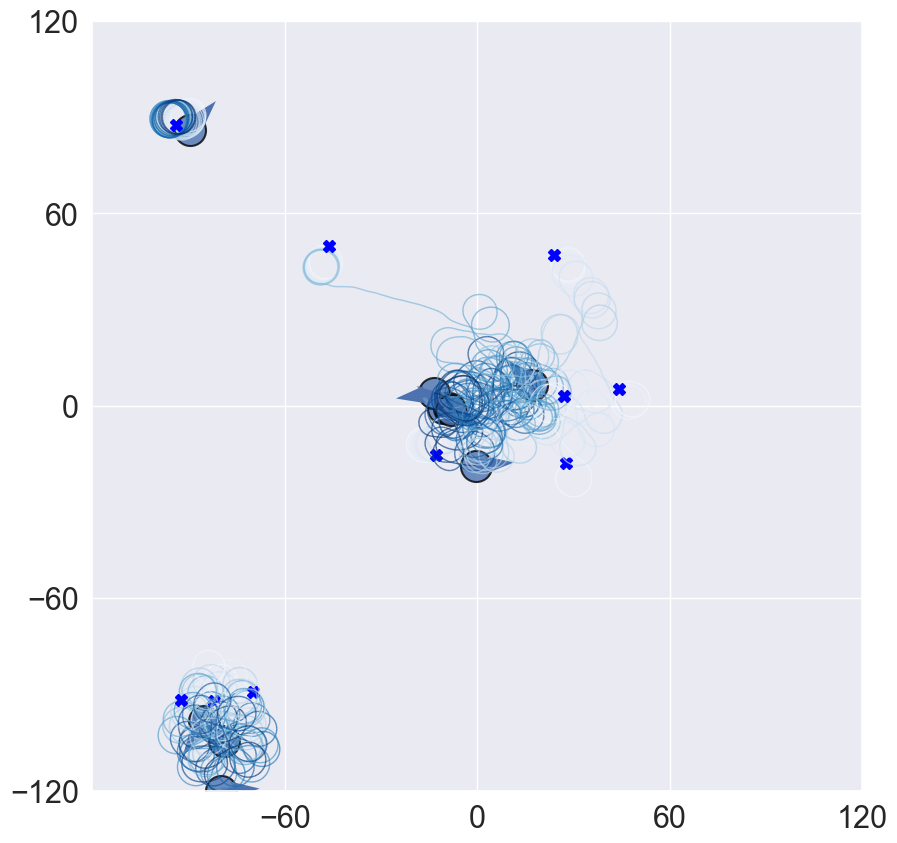

In [5]:
RENDER_DATA_PATH = "./trajectories_s_5/non_ablated/"

forager_xs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_xs.npy')
forager_ys = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_ys.npy')
forager_angs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_angs.npy')
forager_energies = jnp.load(RENDER_DATA_PATH + 'rendering_forager_energies.npy')
print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

forager_xs = jnp.reshape(forager_xs, (forager_xs.shape[0], EP_LEN, NUM_FORAGERS))
forager_ys = jnp.reshape(forager_ys, (forager_ys.shape[0], EP_LEN, NUM_FORAGERS))
forager_angs = jnp.reshape(forager_angs, (forager_angs.shape[0], EP_LEN, NUM_FORAGERS))
forager_energies = jnp.reshape(forager_energies, (forager_energies.shape[0], EP_LEN, NUM_FORAGERS))
print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

forager_xs = forager_xs[0]
forager_ys = forager_ys[0]
forager_angs = forager_angs[0]
forager_energies = forager_energies[0]

print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

print(forager_energies)

render_data = Params(
    content={
        'forager_xs': forager_xs,
        'forager_ys': forager_ys,
        'forager_angs': forager_angs
    }
)
render_static_trajectory(render_data, figname="./figs/non_ablated_s_5.png")

(5, 2000, 10, 1) (5, 2000, 10, 1) (5, 2000, 10, 1) (5, 2000, 10, 1)
(5, 2000, 10) (5, 2000, 10) (5, 2000, 10) (5, 2000, 10)
(2000, 10) (2000, 10) (2000, 10) (2000, 10)
[[  9.98       9.98       9.98     ...   9.98       9.98       9.98    ]
 [  9.959999   9.959999   9.959999 ...   9.959999   9.959999   9.959999]
 [  9.939999   9.939999   9.939999 ...   9.939999   9.939999   9.939999]
 ...
 [-29.960533 -29.960533 -29.960533 ... -29.960533 -29.960533 -29.960533]
 [-29.980534 -29.980534 -29.980534 ... -29.980534 -29.980534 -29.980534]
 [-30.000534 -30.000534 -30.000534 ... -30.000534 -30.000534 -30.000534]]


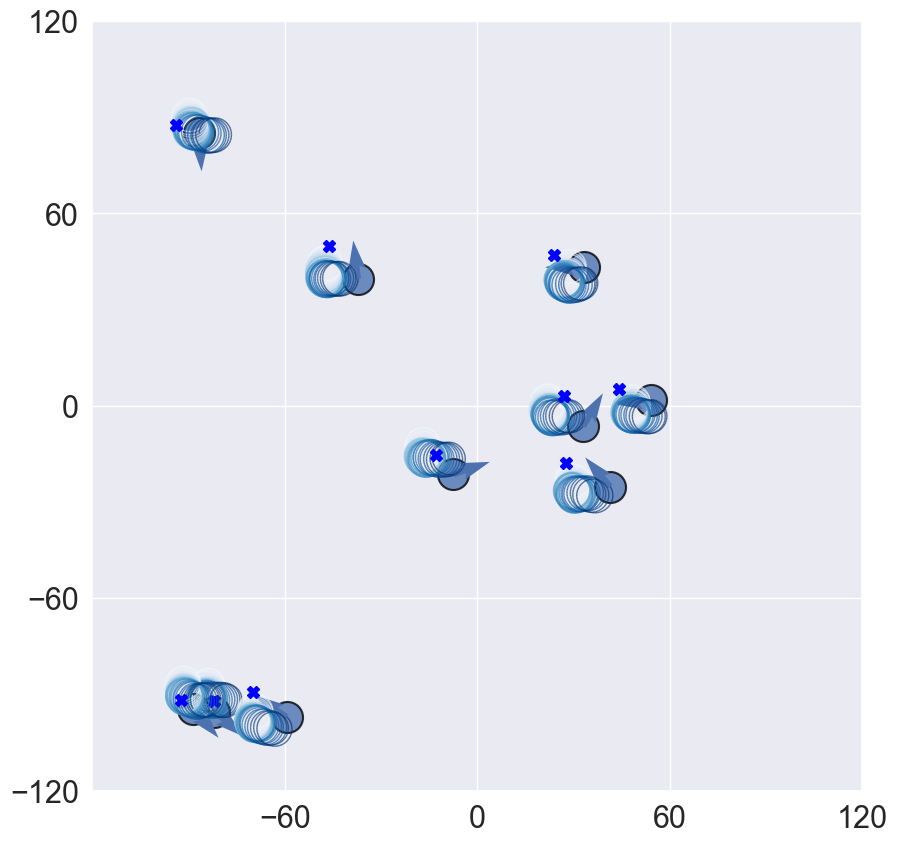

In [6]:
RENDER_DATA_PATH = "./trajectories_s_5/ablated/"

forager_xs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_xs.npy')
forager_ys = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_ys.npy')
forager_angs = jnp.load(RENDER_DATA_PATH + 'rendering_foragers_angs.npy')
forager_energies = jnp.load(RENDER_DATA_PATH + 'rendering_forager_energies.npy')
print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

forager_xs = jnp.reshape(forager_xs, (forager_xs.shape[0], EP_LEN, NUM_FORAGERS))
forager_ys = jnp.reshape(forager_ys, (forager_ys.shape[0], EP_LEN, NUM_FORAGERS))
forager_angs = jnp.reshape(forager_angs, (forager_angs.shape[0], EP_LEN, NUM_FORAGERS))
forager_energies = jnp.reshape(forager_energies, (forager_energies.shape[0], EP_LEN, NUM_FORAGERS))
print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

forager_xs = forager_xs[0]
forager_ys = forager_ys[0]
forager_angs = forager_angs[0]
forager_energies = forager_energies[0]

print(forager_xs.shape, forager_ys.shape, forager_angs.shape, forager_energies.shape)

print(forager_energies)

render_data = Params(
    content={
        'forager_xs': forager_xs,
        'forager_ys': forager_ys,
        'forager_angs': forager_angs
    }
)
render_static_trajectory(render_data, figname="./figs/ablated_s_5.png")

(5, 2000) (5, 2000)
(2000,) (2000,)
(2000,) (2000,)


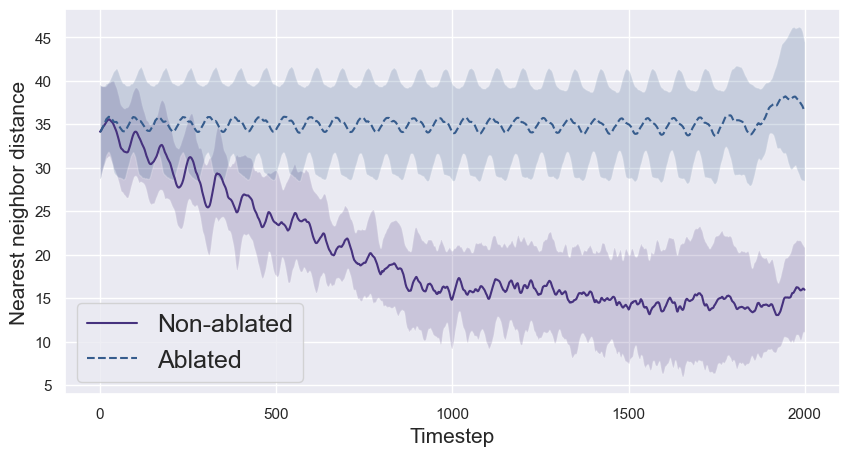

In [7]:
render_data_path_ablated = "./trajectories_s_7/ablated/"
render_data_path_non_ablated = "./trajectories_s_7/non_ablated/"
figname = "./figs/nn_distance_comparison_s_7.png"
plot_nn_distance_comparison(render_data_path_non_ablated, render_data_path_ablated, figname)

(5, 2000) (5, 2000)
(2000,) (2000,)
(2000,) (2000,)


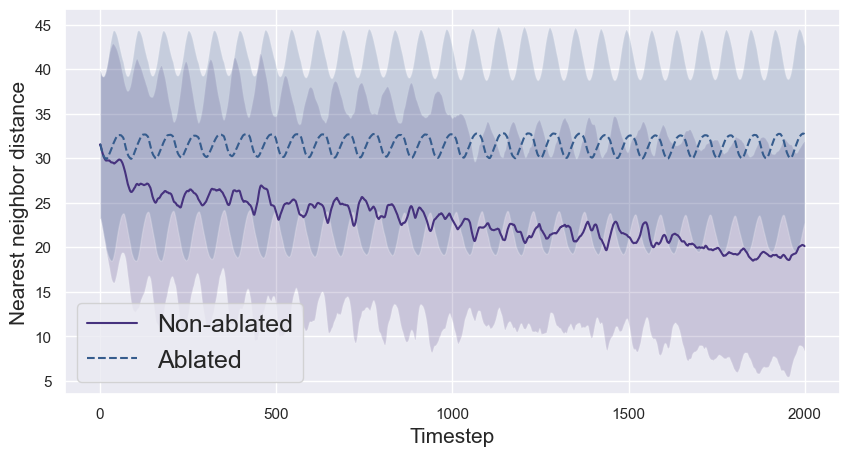

In [8]:
render_data_path_ablated = "./trajectories_s_5/ablated/"
render_data_path_non_ablated = "./trajectories_s_5/non_ablated/"
figname = "./figs/nn_distance_comparison_s_5.png"
plot_nn_distance_comparison(render_data_path_non_ablated, render_data_path_ablated, figname)